<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Qtensor-simulation-times" data-toc-modified-id="Qtensor-simulation-times-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Qtensor simulation times</a></span><ul class="toc-item"><li><span><a href="#Get-cost-estimation" data-toc-modified-id="Get-cost-estimation-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Get cost estimation</a></span><ul class="toc-item"><li><span><a href="#Using-greedy-optimizer" data-toc-modified-id="Using-greedy-optimizer-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Using greedy optimizer</a></span></li><li><span><a href="#Using-tamaki-optimizer" data-toc-modified-id="Using-tamaki-optimizer-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Using tamaki optimizer</a></span></li></ul></li><li><span><a href="#Simulate-the-circuit" data-toc-modified-id="Simulate-the-circuit-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Simulate the circuit</a></span></li><li><span><a href="#Compare-estimation-with-actual-time" data-toc-modified-id="Compare-estimation-with-actual-time-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Compare estimation with actual time</a></span><ul class="toc-item"><li><span><a href="#Explore-costs-for-different-edges" data-toc-modified-id="Explore-costs-for-different-edges-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Explore costs for different edges</a></span></li><li><span><a href="#Determine-dependence-of-estimaiton-vs-time" data-toc-modified-id="Determine-dependence-of-estimaiton-vs-time-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>Determine dependence of estimaiton vs time</a></span></li></ul></li><li><span><a href="#Analyze-simulator-FLOP/s" data-toc-modified-id="Analyze-simulator-FLOP/s-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Analyze simulator FLOP/s</a></span><ul class="toc-item"><li><span><a href="#Plot-time-vs-estimated-FLOP" data-toc-modified-id="Plot-time-vs-estimated-FLOP-1.4.1"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>Plot time vs estimated FLOP</a></span></li><li><span><a href="#Estimate-FLOP/s" data-toc-modified-id="Estimate-FLOP/s-1.4.2"><span class="toc-item-num">1.4.2&nbsp;&nbsp;</span>Estimate FLOP/s</a></span></li><li><span><a href="#Compare-with-matrix-multiplication" data-toc-modified-id="Compare-with-matrix-multiplication-1.4.3"><span class="toc-item-num">1.4.3&nbsp;&nbsp;</span>Compare with matrix multiplication</a></span></li></ul></li></ul></li><li><span><a href="#CLI" data-toc-modified-id="CLI-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>CLI</a></span></li><li><span><a href="#Nbdev-stuff" data-toc-modified-id="Nbdev-stuff-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Nbdev stuff</a></span></li></ul></div>

# Compare qtensor with statevector simulations

In [1]:
#export
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy

import qtensor as qt
from cartesian_explorer import Explorer

In [2]:
#export
import matplotlib as mpl
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color=['#db503d', '#02C6E0'])

In [3]:
#export
ex = Explorer()

## Qtensor simulation times

### Get cost estimation

In [4]:
N = 1000
p = 3
edge_idx = 28
degree = 4
   though I do think a nicer treatment of it would probably be 

In [5]:
gamma, beta = [.1]*p, [.3]*p
graph = qt.toolbox.random_graph(nodes=N, degree=degree, seed=108)

comp = qt.QtreeQAOAComposer(graph, gamma=gamma, beta=beta)

comp.energy_expectation_lightcone(list(graph.edges())[edge_idx])
tn = qt.optimisation.TensorNet.QtreeTensorNet.from_qtree_gates(comp.circuit)
line_graph = tn.get_line_graph()
print('Line graph nodes', line_graph.number_of_nodes())

Line graph nodes 1671


#### Using greedy optimizer

In [6]:
opt = qt.optimisation.Optimizer.DefaultOptimizer()
peo, _ = opt.optimize(tn)
print('treewidth', opt.treewidth)
if opt.treewidth > 100:
    raise Exception('Too large treewidth')
costs, mems = tn.simulation_cost(peo)

treewidth 21


Total FLOPS=0.034049645 G, Memory=0.033554432 G


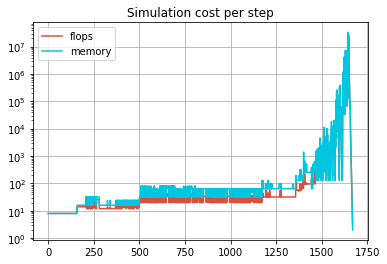

In [7]:
plt.plot(costs, label='flops')
plt.plot(mems, label='memory')
plt.yscale('log')
plt.legend()
plt.grid()
plt.title('Simulation cost per step')
print(f'Total FLOPS={sum(costs)/1e9} G, Memory={max(mems)/1e9} G')

#### Using tamaki optimizer

In [8]:
opt = qt.optimisation.Optimizer.TamakiOptimizer(wait_time=10)
peo, _ = opt.optimize(tn)
print('treewidth', opt.treewidth)
if opt.treewidth > 100:
    raise Exception('Too large treewidth')
costs, mems = tn.simulation_cost(peo)

treewidth 17


Total FLOPS=0.002586149 G, Memory=0.002097152 G


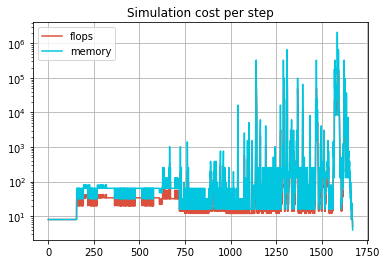

In [9]:
plt.plot(costs, label='flops')
plt.plot(mems, label='memory')
plt.yscale('log')
plt.legend()
plt.grid()
plt.title('Simulation cost per step')
print(f'Total FLOPS={sum(costs)/1e9} G, Memory={max(mems)/1e9} G')

### Simulate the circuit

In [8]:
backend = qt.PerfNumpyBackend(print=False)
sim = qt.QtreeSimulator(bucket_backend=backend)

sim.simulate(comp.circuit)

array([-0.14101067-3.12250226e-17j])

### Compare estimation with actual time

Total time=1.9989681243896484


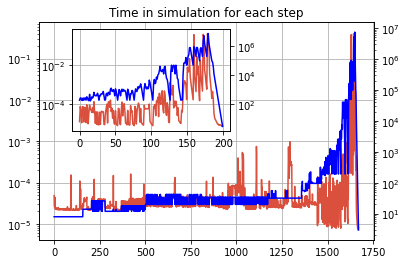

In [9]:
profile_results = backend._profile_results
step_times = [x[1] for x in profile_results.values()]
ignored_vars = tn.bra_vars+tn.ket_vars

plt.plot(step_times[len(ignored_vars):], label='Time')
plt.yscale('log')
plt.grid()

plt.twinx()
plt.plot(costs, label='Theoretical FLOPS', color='blue')
plt.yscale('log')

plt.title('Time in simulation for each step')

lastN = 200
axins = plt.gca().inset_axes([0.1, 0.5, 0.47, 0.47])
axins.plot(step_times[-lastN:] )
axins.set_yscale('log')
axins.grid()

plt.twinx(axins)
plt.plot(costs[-lastN:], color='blue')
plt.yscale('log')


print(f'Total time={sum(step_times)}')

#### Explore costs for different edges

In [10]:
#export
@ex.provider
def graph(n, d, seed):
    return qt.toolbox.random_graph(nodes=n, degree=d, seed=seed)

@ex.provider
def circuit(graph, edge_idx, p):
    gamma, beta = [.1]*p, [.3]*p
    comp = qt.QtreeQAOAComposer(graph, gamma=gamma, beta=beta)
    comp.energy_expectation_lightcone(list(graph.edges())[edge_idx])
    return tuple(comp.circuit)

@ex.provider
def tn(circuit):
    return qt.optimisation.TensorNet.QtreeTensorNet.from_qtree_gates(circuit)

@ex.provider
def peo(tn, ordering_algo='greedy', tamaki_wait_time=15):
    if ordering_algo=='greedy':
        opt = qt.optimisation.Optimizer.DefaultOptimizer()
    elif 'tamaki' in ordering_algo:
        if '_' in ordering_algo:
            _, time_str = ordering_algo.split('_')
            tamaki_wait_time=int(time_str)
        opt = qt.optimisation.Optimizer.TamakiOptimizer(wait_time=tamaki_wait_time)
    peo, _ = opt.optimize(tn)
    return tuple(peo)

@ex.provider
def sim_costs(tn, peo):
    costs, mems = tn.simulation_cost(peo)
    return costs, mems

@ex.provider
def sum_flops(sim_costs):
    flops, mems = sim_costs
    return sum(flops)

In [11]:
#export
@ex.provider
def step_flops(sim_costs):
    flops, mems = sim_costs
    return tuple(flops)

@ex.provider
def max_mem(sim_costs):
    flops, mems = sim_costs
    return max(mems)

In [12]:
#export
SEED=107

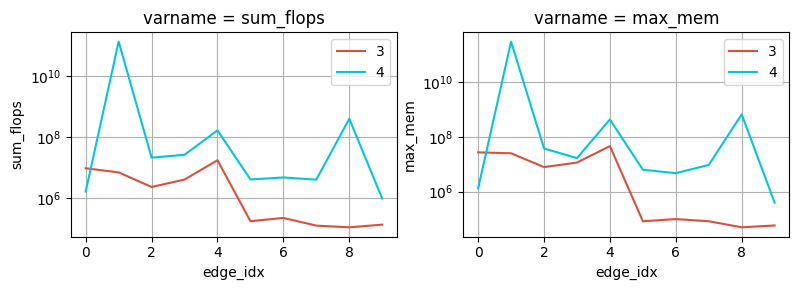

In [13]:
fig = ex.plot_variables2d(('sum_flops', 'max_mem'), n=[N], p=[3],
                          d=[3,4], edge_idx=range(10),
                          seed=[SEED]
                         )
for ax in fig.axes:
    ax.set_yscale('log')
    ax.grid()

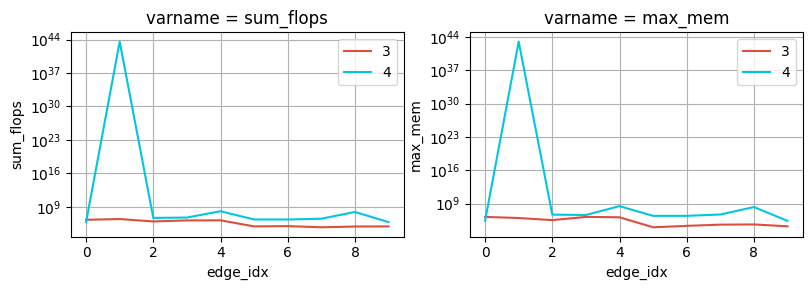

In [34]:
fig = ex.plot_variables2d(('sum_flops', 'max_mem'), n=[N], p=[3],
                          d=[3,4], edge_idx=range(10)
                          ,seed=[SEED]
                          ,ordering_algo=['tamaki_5']
                         )
for ax in fig.axes:
    ax.set_yscale('log')
    ax.grid()

#### Determine dependence of estimaiton vs time

Determine easy edges from previous graphs.


In [14]:
edge_indices = [2]
ds = [3, 4]
p = 3

In [15]:
#export
@ex.provider
def sim_profile(circuit, tn, backend='numpy'):
    if backend == 'numpy':
        backend = qt.PerfNumpyBackend(print=False)
    elif backend == 'mkl':
        backend = qt.ProcessingFrameworks.PerfBackend.from_backend(
            qt.ProcessingFrameworks.CMKLExtendedBackend, print=False)
    elif backend == 'debug_mkl':
        backend = qt.DebugFrameworks.DebugMKLBackend()
    elif backend == 'exatn':
        backend = qt.ProcessingFrameworks.PerfBackend.from_backend(qt.ProcessingFrameworks.ExaTnBackend, print=False)
    sim = qt.QtreeSimulator(bucket_backend=backend)

    sim.simulate(circuit)
    data = backend._profile_results
    return tuple(tuple([tuple(x[0]), x[1]]) for x in data.values())

@ex.provider
def step_sim_time(sim_profile, tn):
    ignored_vars = tn.bra_vars+tn.ket_vars
    times = [x[1] for x in sim_profile]
    return tuple(times[len(ignored_vars):])

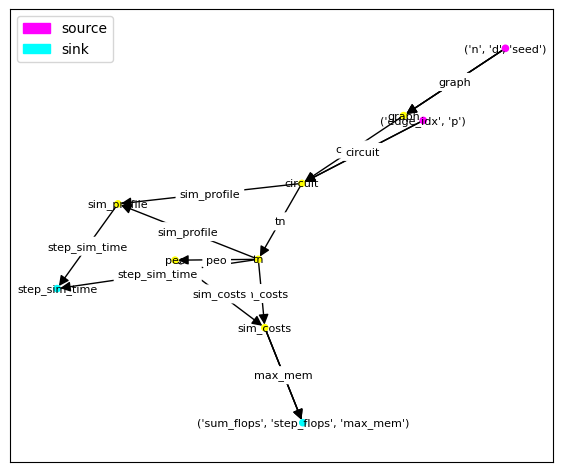

In [16]:
f = ex.draw_dependency_graph(figsize=(7,6), node_size=20)

In [21]:
estimators = ex.map_variable('step_flops', d=ds, edge_idx=edge_indices,
                             n=[N], p=[p], seed=[SEED]
                            )
max(np.max(estimators))

1192070

In [19]:
times = ex.map_variable('step_sim_time', d=ds, edge_idx=edge_indices,
                        n=[N], p=[p], seed=[SEED], backend=['mkl'])

/home/dali/side-projects-hobby/cartesian_explorer/cartesian_explorer/ExplorerBasic.py:72: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  result = np.array(list(tqdm(


Text(0, 0.5, 'Runtime')

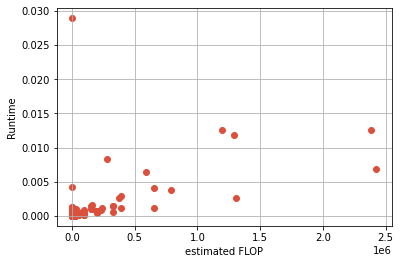

In [22]:
est_flat = np.concatenate(estimators.flatten())
times_flat = np.concatenate(times.flatten())
filt = times_flat<1e-1
plt.scatter(est_flat[filt], times_flat[filt])
plt.grid()
plt.xlabel('estimated FLOP')
plt.ylabel('Runtime')

### Analyze simulator FLOP/s

#### Plot time vs estimated FLOP

In [27]:
#export
def plot_with_filter(est_flat, times_flat):
    filt = (est_flat>5e4) #& (times_flat>1e-4)
    est_flat_filtered = est_flat[filt]
    times_flat_filtered = times_flat[filt]

    # Fit times
    log_fit_coef = np.polyfit(np.log(est_flat_filtered), np.log(times_flat_filtered), 1)
    fit_coef = np.polyfit(est_flat_filtered, times_flat_filtered, 1)
    def fixed_slope(x, shift):
        slope = 1.0
        return x*slope + shift
    popt, pcov = scipy.optimize.curve_fit(fixed_slope, np.log(est_flat_filtered), np.log(times_flat_filtered))
    print('Lin fit:', fit_coef)
    print('Log fit:', log_fit_coef)
    print('Slope-1 log fit:', popt)
    fit_fn = np.poly1d(log_fit_coef)
    fit_fn = fixed_slope

    # Plot scatter with filtered data
    plt.scatter(est_flat_filtered, times_flat_filtered, marker='x')
    min_x = np.log10(est_flat_filtered.min())
    max_x = np.log10(est_flat_filtered.max()) + .5
    xfit = 10**np.linspace(min_x, max_x, 100)
    plt.plot(xfit, np.exp(fit_fn(np.log(xfit), popt[0])), color='blue')
    plt.loglog()
    plt.xlabel('estimated FLOP')
    plt.ylabel('Runtime')
    plt.grid()
    return log_fit_coef, fit_coef

Lin fit: [ 3.95588723e-08 -8.67827872e-03]
Log fit: [  1.29641774 -22.79449518]
Slope-1 log fit: [-19.11949889]


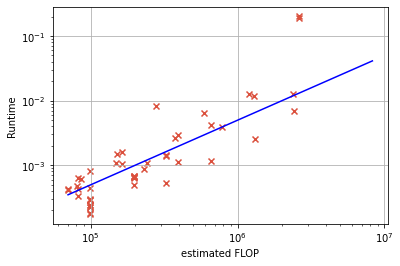

In [28]:
log_fit_coef, fit_coef = plot_with_filter(est_flat, times_flat)

Let's estimate our factual FLOPS on a laptop from worst-case on linear plot


#### Estimate FLOP/s

In [29]:
FLOP = 1e6/.03
print(f'Factual FLOPS on a laptop {FLOP:e}')

Factual FLOPS on a laptop 3.333333e+07


Or use logarithmic fit


In [30]:
FLOP_logfit = np.exp(-log_fit_coef[1])
print(f'Factual FLOPS on a laptop, from log fit {FLOP_logfit:e}')

Factual FLOPS on a laptop, from log fit 7.934571e+09


#### Compare with matrix multiplication

In [31]:
N = 500
matmul_flop = N**2*(N-1)
x, y = np.random.randn(2, N, N)
%timeit np.matmul(x,y)

4.45 ms ± 487 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [32]:
#export
import timeit
def get_log_flops_vs_matmul(log_fit_coef):
    FLOPS_logfit = np.exp(-log_fit_coef[1])

    N = 500
    matmul_flop = N**2*(N-1)
    x, y = np.random.randn(2, N, N)
    number = 100
    matmul_time = timeit.timeit(lambda: np.matmul(x,y)
                               , number=number)/number

    FLOPS_matmul = matmul_flop/matmul_time
    
    return FLOPS_logfit, FLOPS_matmul

In [33]:
FLOP_logfit, FLOPS_matmul = get_log_flops_vs_matmul(log_fit_coef)
print(f'Simulator inefficiency: {FLOPS_matmul/FLOP_logfit}')
print(f'Simulator optimality: {FLOP_logfit/FLOPS_matmul}')

Simulator inefficiency: 1.9337510525337913
Simulator optimality: 0.5171296474226614


In [34]:
FLOPS_matmul = matmul_flop/4.65e-3
print(f'FLOPS on this laptop for matrix mul: {FLOPS_matmul:e}')

FLOPS on this laptop for matrix mul: 2.682796e+10


## CLI

Use click to run some scripts from this notebook

In [51]:
print(f'Simulator inefficiency: {FLOPS_matmul/FLOP_logfit}')
print(f'Simulator optimality: {FLOP_logfit/FLOPS_matmul}')

NameError: name 'FLOPS_matmul' is not defined

In [35]:
# export
import click

@click.group()
def cli():
    pass

@click.argument('filename', nargs=-1)
@click.option('-B', '--backend', default='numpy')
@click.option('-M', '--max-memory', default=3e8)
@click.option('-s', '--seed', default=SEED)
@click.option('-O', '--ordering_algo', default='greedy'
              ,help=("One of (greedy, tamaki, tamaki_{wait_time})"
                     "'tamaki_15' means heuristic solver running for 15 seconds per graph"
                    )
             )
@click.option('--min-memory', default=3e6)
def time_vs_flops_plot(filename=None, backend='numpy', seed=SEED,
                       max_memory=2e8, min_memory=1e6,
                       ordering_algo='greedy'
                      ):
    """
    Plots times and estimated FLOP for each step of several QAOA energy computation contractions.
    
    Currently using 
        - random regular graphs with degree=3,4 
        - p = 3
        - N = 1000
        
    """
    ds = [3, 4]
    p = 3
    N = 1000
    
    edges_to_try = 20
    estimators, maxmems = ex.map_variables(
        ('step_flops', 'max_mem'),
         d=ds,
         edge_idx=range(edges_to_try), n=[N], p=[p],
         seed=[seed],
         ordering_algo=[ordering_algo],
        )
    
    
    selector = ((min_memory < maxmems) & (maxmems < max_memory)).all(axis=0)
    edge_indices = np.arange(edges_to_try)[selector]
    print('Selected edges', edge_indices)
    print('Estimated memories', maxmems.T[selector].flatten())
    estimators = estimators.T[selector]
        
    times = ex.map_variable('step_sim_time', d=ds,
                            edge_idx=edge_indices, n=[N], p=[p]
                            ,seed=[seed]
                            ,backend=[backend]
                            ,ordering_algo=[ordering_algo]
                           )
    
    est_flat = np.concatenate(estimators.T.flatten())
    times_flat = np.concatenate(times.flatten())
    
    log_fit_coef, fit_coef = plot_with_filter(est_flat, times_flat)
    if filename:
        plt.savefig(filename[0])
    
    fit, matmul = get_log_flops_vs_matmul(log_fit_coef)
    
    print('===Results===')
    print(f'Total time: {times_flat.sum():.5}')
    print(f'Simulator fitted flops: {fit/1e9:.5} G')
    print(f'Matmul flops: {matmul/1e9:.5} G')
    print(f'Simulator optimality: {fit/matmul}')

cli.command()(time_vs_flops_plot)

<Command time-vs-flops-plot>


Selected edges [ 0  2  3  4 10 13 16]
Estimated memories [27262976 1310720 7864320 37748736 11534336 16777216 46137344 436207616
 3145728 83886080 2621440 14680064 13631488 5767168]


/home/dali/side-projects-hobby/cartesian_explorer/cartesian_explorer/ExplorerBasic.py:72: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  result = np.array(list(tqdm(



Lin fit: [2.11670890e-08 6.72474995e-03]
Log fit: [  1.33334429 -23.18701601]
Slope-1 log fit: [-18.95265756]
===Results===
Total time: 9.8551
Simulator fitted flops: 11.749 G
Matmul flops: 28.388 G
Simulator optimality: 0.41387031429035953



Selected edges [ 0  2  3  4 10 13 16]
Estimated memories [27262976 1310720 7864320 37748736 11534336 16777216 46137344 436207616
 3145728 83886080 2621440 14680064 13631488 5767168]


/home/dali/side-projects-hobby/cartesian_explorer/cartesian_explorer/ExplorerBasic.py:72: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  result = np.array(list(tqdm(



Lin fit: [ 1.61124218e-08 -1.83452513e-03]
Log fit: [  1.25167296 -22.48619316]
Slope-1 log fit: [-19.28927764]
===Results===
Total time: 6.3469
Simulator fitted flops: 5.8295 G
Matmul flops: 23.118 G
Simulator optimality: 0.2521579552905311


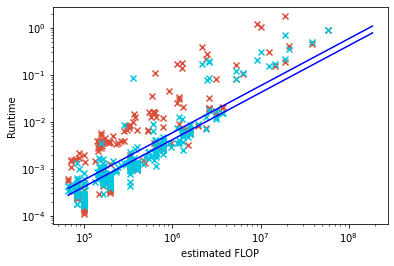

In [36]:
time_vs_flops_plot(max_memory=5e8, min_memory=1e6)
time_vs_flops_plot(max_memory=5e8, min_memory=1e6, backend='mkl')

## Nbdev stuff

In [37]:
#hide
#default_exp time_vs_flop

In [39]:
from nbdev.export  import *
notebook2script()

Converted QAOA_bench.ipynb.
Converted Time_vs_FLOP.ipynb.
